# An Analysis of Poets through an exploration of supervised and unsupervised techniques

## Project Objectives
* Utilize clustering with NLP
* Create a satifactory model for poet identification from their work
* Practice NLP techniques
* Have fun!

In [2]:
import time
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import gutenberg
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn import neighbors, ensemble,tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit

import warnings 
warnings.simplefilter('ignore')

# Bag of Words - Data Preparation

In [51]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
leaves = gutenberg.raw('whitman-leaves.txt')
paradise = gutenberg.raw('milton-paradise.txt')
blake = gutenberg.raw('blake-poems.txt')
hiawatha = open("The Song Of Hiawatha, by Henry W. Longfellow.txt")
hiawatha = hiawatha.read()
endymion = open("Endymion, by John Keats.txt")
endymion = endymion.read()
odyssey = open("The Odyssey by Homer.txt")
odyssey = odyssey.read()
burns = open("The Complete Works of Robert Burns.txt")
burns = burns.read()
sea = open("Sea Garden by Hilda Doolittle.txt")
sea = sea.read()
beowulf = open("Beowulf by Leslie Hall.txt")
beowulf = beowulf.read()
sappho = open("Sappho- One Hundred Lyrics by Bliss Carman.txt")
sappho = sappho.read()


# unique cleaning
paradise = re.sub(r'Book \D{1,3}', '', paradise)
endymion = re.sub(r'BOOK \D{1,3}', '', endymion)
odyssey = re.sub(r'BOOK \D{1,3}', '', odyssey)
odyssey = re.sub(r'ARGUMENT', '', odyssey)
blake = re.sub(r"[A-Z]+\b","",blake)
blake = re.sub(r"and   of","",blake)
beowulf = re.sub(r"^[A-Z]+\b.","",beowulf)
beowulf = re.sub(r"(\s*[A-Z])*\s*[A-Z]\.","",beowulf)
sea = re.sub(r"(\s*[A-Z])*\s*[A-Z]\b","",sea)
burns = re.sub(r"(\s*[A-Z])*\s*[A-Z]\.", "",burns)
sappho = re.sub(r"I", "",sappho)


paradise = text_cleaner(paradise[:int(len(paradise)/100)])
blake = text_cleaner(blake[:int(len(blake)/7)])
leaves = text_cleaner(leaves[:int(len(leaves)/150)])
hiawatha = text_cleaner(hiawatha[:int(len(hiawatha)/22)])
endymion = text_cleaner(endymion[:int(len(endymion)/18)])
odyssey = text_cleaner(odyssey[:int(len(odyssey)/150)])
burns = text_cleaner(burns[:int(len(burns)/350)])
sea = text_cleaner(sea[:int(len(sea)/6)])
beowulf = text_cleaner(beowulf[:int(len(beowulf)/50)])
sappho = text_cleaner(sappho[:int(len(sappho)/10)])

Imported and cleaned text to make it suitable for Bag of Words analysis

In [52]:
# Parse the cleaned novels.
nlp = spacy.load('en')
paradise_doc = nlp(paradise)
blake_doc = nlp(blake)
leaves_doc = nlp(leaves)
hiawatha_doc = nlp(hiawatha)
endymion_doc = nlp(endymion)
odyssey_doc = nlp(odyssey)
burns_doc = nlp(burns)
sea_doc = nlp(sea)
beowulf_doc = nlp(beowulf)
sappho_doc = nlp(sappho)


Parsed the texts using Spacy to allow token manipulation and analysis

In [53]:
# Group into sentences.
paradise_sents = [[sent, "Milton"] for sent in paradise_doc.sents]
blake_sents = [[sent, "Blake"] for sent in blake_doc.sents]
leaves_sents = [[sent, "Whitman"] for sent in leaves_doc.sents]
hiawatha_sents = [[sent, "Longfellow"] for sent in hiawatha_doc.sents]
endymion_sents = [[sent, "Keats"] for sent in endymion_doc.sents]
odyssey_sents = [[sent, "Homer"] for sent in odyssey_doc.sents]
burns_sents = [[sent, "Burns"] for sent in burns_doc.sents]
sea_sents = [[sent, "Doolittle"] for sent in sea_doc.sents]
beowulf_sents = [[sent, "Beowulf"] for sent in beowulf_doc.sents]
sappho_sents = [[sent, "Sappho"] for sent in sappho_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(paradise_sents + blake_sents + 
                         leaves_sents + hiawatha_sents + 
                         endymion_sents + odyssey_sents +
                         burns_sents[:350] + sea_sents +
                         beowulf_sents + sappho_sents)
sentences.head()

,0,1
0,"(Of, Man, 's, first, disobedience, ,, and, the...",Milton
1,"(And, chiefly, thou, ,, O, Spirit, ,, that, do...",Milton
2,"(Say, first, for, Heaven, hides, nothing, from...",Milton
3,"(Who, first, seduced, them, to, that, foul, re...",Milton
4,"(Th, ', infernal, Serpent, ;, he, it, was, who...",Milton


Created a dataframe with the sentences and label them with their author.

In [54]:
# Utility function to create a list of the 3000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(4000)]

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
blakewords = bag_of_words(blake_doc)
paradisewords = bag_of_words(paradise_doc)
leaveswords = bag_of_words(leaves_doc)
hiawathawords = bag_of_words(hiawatha_doc)
endymionwords = bag_of_words(endymion_doc)
odysseywords = bag_of_words(odyssey_doc)
burnswords = bag_of_words(burns_doc)
seawords = bag_of_words(sea_doc)
beowulfwords = bag_of_words(beowulf_doc)
sapphowords = bag_of_words(sappho_doc)

# Combine bags to create a set of unique words.
common_words = set(blakewords + paradisewords + 
                   leaveswords + hiawathawords + 
                   endymionwords + odysseywords +
                   burnswords + seawords +
                   beowulfwords +sapphowords)

Defined bag of words and bag of words features to create a set of unique words.

In [55]:
# Create our data frame with features. This can take a while to run.
start_time = time.time()
print('Processing...')

word_counts = bow_features(sentences, common_words)

t= round((time.time() - start_time),4)
print("\n -- %s seconds --\n" % t)

word_counts.head()

Processing...
Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500

 -- 231.1509 seconds --



,verse,person,silly,lange,erstwhile,tamely,cloot,wild,adopt,wat,...,omahas,darkening,silvery,ivy,hitch,cam,dank,trumpet,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Of, Man, 's, first, disobedience, ,, and, the...",Milton
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(And, chiefly, thou, ,, O, Spirit, ,, that, do...",Milton
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Say, first, for, Heaven, hides, nothing, from...",Milton
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Who, first, seduced, them, to, that, foul, re...",Milton
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Th, ', infernal, Serpent, ;, he, it, was, who...",Milton


Applied the bag of words features to create a dataframe of count of each word.

In [56]:
# Define the features and the outcome.
bow_y = word_counts['text_source']
bow_X = np.array(word_counts.drop(['text_sentence','text_source'],axis= 1))

# Normalize the data.
bow_X_norm = normalize(bow_X)

# Reduce it to two components.
bow_X_pca = PCA(2).fit_transform(bow_X_norm)


Set X and y variables, then normalized and performed PCA on X so that clustering would actually be achievable with computational limitations.  Using the first two components of PCA provides us with a vast majority of the data of the 2000+ features we have, to make modelling more computationally reasonable.

# Bag Of Words - Clustering

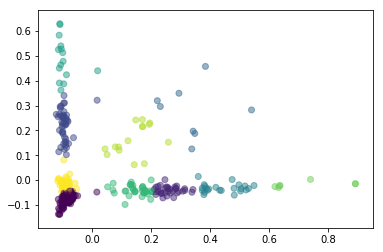

Comparing k-means clusters against the data:
text_source  Beowulf  Blake  Burns  Doolittle  Homer  Keats  Longfellow  \
row_0                                                                     
0                 37     22     31         20     27     26          19   
1                  3      2      4          7      4      6           1   
2                  2      9      1          1      3      9           6   
3                  0      3      0          0      0      3           0   
4                  1      1      5          1      3      2           4   
5                  0      6      3          0      1      0           3   
6                  2      0      8          4      4      5           3   
7                  1      2      2          0      1      0           1   
8                  1      4      0          0      1      2           3   
9                 11     10      5          4     10     15          10   

text_source  Milton  Sappho  Whitman  
row_0          

In [57]:
#KMeans Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans = kmeans.fit(bow_X_pca)
y_pred = kmeans.predict(bow_X_pca)

# Plot the solution.
plt.scatter(bow_X_pca[:, 0], bow_X_pca[:, 1], c=y_pred, alpha = 0.5)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, bow_y))

print("--- %s seconds for model fit ---" % (time.time() - start_time))

print('\nSilhoette Score:', silhouette_score(bow_X_pca, y_pred))

KMeans clustering achieved a decent silhoette score, let's see how other clustering agorithms perform.

In [59]:
#MiniBatch KMeans Clustering
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=200)
minibatchkmeans.fit(bow_X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(bow_X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

print('\nSilhoette Score:',silhouette_score(bow_X_pca, predict_mini))

Comparing k-means and mini batch k-means solutions:
col_0    0   1   2  3   4   5   6  7  8   9
row_0                                      
0        0   0   0  0   0   0   0  0  0  62
1        0   0   0  0   0  15   0  0  0   0
2        1   0   0  0   0   0  10  0  6   0
3        0   0   0  1  23   0   0  7  0   0
4        0   0   0  7   0   0   0  0  8   0
5        0  34   0  0   0   0  25  0  1   0
6      135   0   0  0   0   0   0  0  0   0
7       32   0   0  0   0   0   0  0  0   0
8       80   0   0  0   0   0   0  0  0  20
9        0   0  46  0   0   0   0  0  0   0

Silhoette Score: 0.40341300812743813


MiniBatchKMeans performs a little worse, which is to be expected since it's running off less data than KMeans

Number of estimated clusters: 10


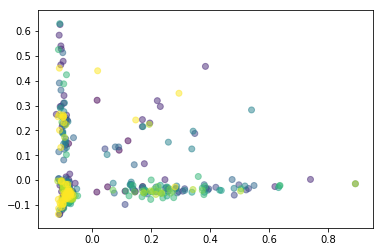

Comparing the assigned categories to the ones in the data:
text_source   0   1   2   3   4   5   6   7   8   9
row_0                                              
0            11  22  16  19  26  27  31  20  37  39
1             0   2   6   1   6   4   4   7   3   1
2             4   9   2   6   9   3   1   1   2   9
3             0   3   1   0   3   0   0   0   0   1
4             0   1   6   4   2   3   5   1   1   0
5             0   6   0   3   0   1   3   0   0   2
6             4   0   5   3   5   4   8   4   2   0
7             0   2   0   1   0   1   2   0   1   0
8             2   4   1   3   2   1   0   0   1   1
9             3  10   5  10  15  10   5   4  11   9


In [60]:
#MeanShift Clustering
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(bow_X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
MS = MeanShift(bandwidth=bandwidth, bin_seeding=True)
MS.fit(bow_X_pca)

predict_means = MS.predict(bow_X_pca)

# Coordinates of the cluster centers.
cluster_centers = MS.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(bow_X_pca[:, 0], bow_X_pca[:, 1], c=labels, alpha=0.5)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_pred,labels))

#silhouette_score(X_pca, predict_means)

The MeanShift model predicted all of the same class and therefore could not generate a silhoette score with a class size of 1.

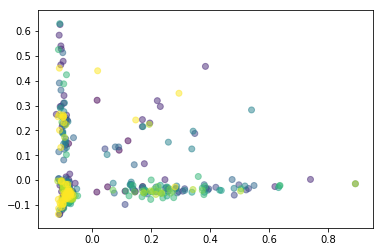

Comparing the assigned categories to the ones in the data:
col_0    0   1   2  3  4  5   6  7  8  9
row_0                                   
0      247   0   0  0  0  0   0  1  0  0
1        0  34   0  0  0  0   0  0  0  0
2        0   0  46  0  0  0   0  0  0  0
3        0   0   0  0  8  0   0  0  0  0
4        0  23   0  0  0  0   0  0  0  0
5        0   0   1  0  0  0  14  0  0  0
6        0  34   0  0  0  0   0  0  0  1
7        0   0   0  7  0  0   0  0  0  0
8        0   2   5  0  8  0   0  0  0  0
9       78   0   2  0  0  1   0  0  1  0

Silhoette Score: 0.29321325437046153


In [61]:
#Spectral Clustering
# We know we're looking for 10 clusters.
n_clusters = len(np.unique(labels))

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(bow_X_pca)

#Predicted clusters.
predict_sc=sc.fit_predict(bow_X_pca)

#Graph results.
plt.scatter(bow_X_pca[:, 0], bow_X_pca[:, 1], c=labels, alpha=0.5)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_pred,predict_sc))

print('\nSilhoette Score:',silhouette_score(bow_X_pca, predict_sc))

Spectral Clustering performs worse than KMeans.

# Bag Of Words - Modelling

In [63]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25,
                                                    stratify = y,
                                                    random_state=0)

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

In [64]:
# Spot Check Algorithms
models = []
models.append(('NBB', BernoulliNB()))
models.append(('RFC', ensemble.RandomForestClassifier()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('DTC', tree.DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('GBC', ensemble.GradientBoostingClassifier()))
models.append(('ABC', ensemble.AdaBoostClassifier()))
models.append(('ETC', ensemble.ExtraTreesClassifier()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('GMM', GaussianMixture()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    split = StratifiedShuffleSplit(n_splits=10, random_state=1337)
    model = model.fit(X_train,y_train)
    cv_results = cross_val_score(model, X_test, y_test, cv=split, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NBB: 0.192308 (0.070920)
RFC: 0.253846 (0.097604)
KNN: 0.146154 (0.053846)
DTC: 0.176923 (0.060079)
GNB: 0.392308 (0.087368)
SVC: 0.153846 (0.000000)
GBC: 0.269231 (0.062017)
ABC: 0.153846 (0.034401)
ETC: 0.307692 (0.137604)
QDA: 0.069231 (0.053846)


We see somewhat poor performance with no model performing better than KMeans clustering for poet identification.

In [65]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

#print('Training set score:', rfc.score(X_train, y_train))
#print('\nTest set score:', rfc.score(X_test, y_test))

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(rfc, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)


Cross Validation:
    0.28 (+/- 0.06)
[0.30769231 0.30769231 0.30769231 0.30769231 0.15384615]


In [66]:
lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
lr.fit(X_train, y_train)

#print('Training set score:', lr.score(X_train, y_train))
#print('\nTest set score:', lr.score(X_test, y_test))

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(lr, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)


Cross Validation:
    0.43 (+/- 0.10)
[0.30769231 0.46153846 0.38461538 0.61538462 0.38461538]


In [67]:
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, y_train)

#print('Training set score:', clf.score(X_train, y_train))
#print('\nTest set score:', clf.score(X_test, y_test))


split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(clf, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)


Cross Validation:
    0.25 (+/- 0.06)
[0.15384615 0.30769231 0.30769231 0.23076923 0.23076923]


It seems for Bag Of Words, clustering performed the best. 

Before we draw any conclusions, let's see how TF-IDF analysis performs.

# TF-IDF  - Data Preparation

In [3]:
# Load and clean the data.
leaves = gutenberg.paras('whitman-leaves.txt')
leaves_paras=[]
for paragraph in leaves:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    leaves_paras.append(' '.join(para))

paradise = gutenberg.paras('milton-paradise.txt')
paradise_paras=[]
for paragraph in paradise:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    paradise_paras.append(' '.join(para))
    
    
blake = gutenberg.paras('blake-poems.txt')
blake_paras=[]
for paragraph in blake:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    blake_paras.append(' '.join(para))

    
new_corpus = PlaintextCorpusReader("",'.txt')    
    
hiawatha = new_corpus.paras("The Song Of Hiawatha, by Henry W. Longfellow.txt")
hiawatha_paras=[]
for paragraph in hiawatha:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    hiawatha_paras.append(' '.join(para))


endymion = new_corpus.paras("Endymion, by John Keats.txt")
endymion_paras=[]
for paragraph in endymion:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    endymion_paras.append(' '.join(para))


odyssey = new_corpus.paras("The Odyssey by Homer.txt")
odyssey_paras=[]
for paragraph in odyssey:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    odyssey_paras.append(' '.join(para))


burns = new_corpus.paras("The Complete Works of Robert Burns.txt")
burns_paras=[]
for paragraph in burns:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    burns_paras.append(' '.join(para))


sea = new_corpus.paras("Sea Garden by Hilda Doolittle.txt")
sea_paras=[]
for paragraph in sea:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    sea_paras.append(' '.join(para))
    

beowulf = new_corpus.paras("Beowulf by Leslie Hall.txt")
beowulf_paras=[]
for paragraph in beowulf:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    beowulf_paras.append(' '.join(para))


sappho = new_corpus.paras("Sappho- One Hundred Lyrics by Bliss Carman.txt")
sappho_paras=[]
for paragraph in sappho:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    sappho_paras.append(' '.join(para))


Great, now we've import each of the texts as paragraphs with some cleaning

In [4]:
# Group into paragraphs.
paradise_paras = [[para, "Milton"] for para in paradise_paras]
blake_paras = [[para, "Blake"] for para in blake_paras]
leaves_paras = [[para, "Whitman"] for para in leaves_paras]
hiawatha_paras = [[para, "Longfellow"] for para in hiawatha_paras]
endymion_paras = [[para, "Keats"] for para in endymion_paras]
odyssey_paras = [[para, "Homer"] for para in odyssey_paras]
burns_paras = [[para, "Burns"] for para in burns_paras]
sea_paras = [[para, "Doolittle"] for para in sea_paras]
beowulf_paras = [[para, "Beowulf"] for para in beowulf_paras]
sappho_paras = [[para, "Sappho"] for para in sappho_paras]

# Combine the sentences from the two novels into one data frame.
paragraphs = pd.DataFrame(paradise_paras + blake_paras + 
                         leaves_paras + hiawatha_paras + 
                         endymion_paras + odyssey_paras +
                         burns_paras + sea_paras +
                         beowulf_paras + sappho_paras)
#paragraphs.columns = ['paragraph','label']
paragraphs.head()

,0,1
0,[ Paradise Lost by John Milton 1667 ],Milton
1,Book I,Milton
2,"Of Man ' s first disobedience , and the fruit ...",Milton
3,Book II,Milton
4,"High on a throne of royal state , which far Ou...",Milton


Now we have each paragraph labeled in a dataframe and ready for analysis!

In [5]:
# Define the features and the outcome.
X = paragraphs.drop(1,axis = 1)
y = paragraphs[1]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.25, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
paras_tfidf=vectorizer.fit_transform(paragraphs.drop(1,axis=1)[0].tolist())
#print("Number of features: %d" % paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(paras_tfidf, test_size=0.25, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of sentences
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per sentence
tfidf_bysent = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the data.
X_train_norm = normalize(X_train_tfidf_csr)
X_test_norm = normalize(X_test_tfidf_csr)


We've:
* split our data
* vecotrized the data for TF-IDF 
* converted to condensed sparse row form
* normalized the data for anaylsis

# TF-IDF - Clustering

In [6]:
# Calculate predicted clusters for KMeans.
KMN = KMeans(n_clusters=10, random_state=42)
KMN = KMN.fit(X_train_norm)
y_pred = KMN.predict(X_train_norm)
print('Silhoette Score:',silhouette_score(X_train_norm, y_pred))

Silhoette Score: 0.08457321695207078


KMeans custering with a poor silhoette score, let's see if other cluster models will perform any better

In [24]:
#MiniBatch KMeans Clustering
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=200)
minibatchkmeans.fit(X_train_norm)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_train_norm)

print('Silhoette Score:',silhouette_score(X_train_norm, predict_mini))

Silhoette Score: 0.07737890383543905


Unfortunately the mini batch kmeans performed slightly worse than regular kmeans

In [40]:
#MeanShift Clustering
start_time = time.time()
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_norm.toarray(), quantile=0.3, n_samples=2)

# Declare and fit the model.
MS = MeanShift(bandwidth=bandwidth, bin_seeding=True)
MS = MS.fit(X_train_norm.toarray())
predict_means = MS.predict(X_train_norm.toarray())

# Coordinates of the cluster centers.
cluster_centers = MS.cluster_centers_

# Count our clusters.
n_clusters_ = 10
print("Number of estimated clusters: {}".format(n_clusters_))

#print('Comparing the assigned categories to the ones in the data:')
#print(pd.crosstab(y_pred,labels))

print('\nSilhoette Score:', silhouette_score(X_train_norm, predict_means))

t= round((time.time() - start_time),4)
print("\n -- %s seconds for results--" % t)

Number of estimated clusters: 10

Silhoette Score: 0.020374525008515325

 -- 76.9427 seconds for results--


Performance is quite poor for MeanShift clustering, but admittedly there were some limitations of compuational power. regardless, it's safe to assume the model wouldn't perform much better with less limitations.

In [10]:
#Spectral Clustering
# We know we're looking for 10 clusters.
n_clusters = 10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc = sc.fit(X_train_norm)
#Predicted clusters.
predict_sc=sc.fit_predict(X_test_norm)

print('\nSilhoette Score:',silhouette_score(X_test_norm, predict_sc))


Silhoette Score: 0.1070578322604148


Spectral Clustering seemed to perform the best, but its hardly a feat given the poor performance of all the clustering models.

Let's see how supervised modeling fairs for TF-IDF

# TF-IDF - Modelling

In [42]:
# Spot Check Algorithms
start_time = time.time()
models = []
models.append(('NBB', BernoulliNB()))
models.append(('RFC', ensemble.RandomForestClassifier()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('DTC', tree.DecisionTreeClassifier()))
models.append(('SVC', SVC()))
models.append(('GBC', ensemble.GradientBoostingClassifier()))
models.append(('ABC', ensemble.AdaBoostClassifier()))
models.append(('ETC', ensemble.ExtraTreesClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    split = StratifiedShuffleSplit(n_splits=10, random_state=1337)
    model = model.fit(X_train_tfidf_csr,y_train)
    cv_results = cross_val_score(model, X_test_tfidf_csr, y_test, cv=split, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
t= round((time.time() - start_time),4)
print("\n -- %s seconds for results--" % t)

NBB: 0.724885 (0.009622)
RFC: 0.756221 (0.015722)
KNN: 0.688018 (0.002112)
DTC: 0.727189 (0.020997)
SVC: 0.686636 (0.000000)
GBC: 0.747005 (0.006741)
ABC: 0.693318 (0.002406)
ETC: 0.771198 (0.009993)

 -- 395.3001 seconds for results--


Took some time but we're seeing some pretty good results, much better than Bag Of Words!

In [7]:
#setting the split
split = StratifiedShuffleSplit(n_splits=10, random_state=1337)

In [43]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train_tfidf_csr, y_train)

score = cross_val_score(rfc, X_test_tfidf_csr, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)


Cross Validation:
    0.76 (+/- 0.02)
[0.73963134 0.75115207 0.76267281 0.79032258 0.75115207 0.77419355
 0.76497696 0.74193548 0.7764977  0.73732719]


In [44]:
lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it to be explicit.
lr.fit(X_train_tfidf_csr, y_train)

score = cross_val_score(lr, X_test_tfidf_csr, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)


Cross Validation:
    0.71 (+/- 0.01)
[0.71889401 0.70967742 0.70967742 0.70506912 0.71198157 0.7235023
 0.70967742 0.70506912 0.71658986 0.71889401]


In [45]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_tfidf_csr, y_train)

score = cross_val_score(lr, X_test_tfidf_csr, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)


Cross Validation:
    0.71 (+/- 0.01)
[0.71889401 0.70967742 0.70967742 0.70506912 0.71198157 0.7235023
 0.70967742 0.70506912 0.71658986 0.71889401]


# Summary
Looks like the clustering performed a bit better on the Bag Of Words preparation of these texts but the supervised models performedd significantly better with the TF-IDF preparation.

## Obstacles

I believe part of the reason it has been difficult to model is due to the nature of the texts. Some of them are collections of different poems by a poet while others are one long poem by a poet. The potential multiple topics in the collections likely make it more difficult to identify a central characteristics of the poet. Or maybe it's the fact that it is mixed; if they were all collections or all one long poem, perhaps the models would perform better!